# Classification with an Academic Success 🎓

This notebook aims to create a comprehensible walkthrough for the Machine Leaning Classification Problem **Classification with an Academic Success Dataset** part of the Playground Series from Kaggle: https://www.kaggle.com/competitions/playground-series-s4e6/overview

The dataset for this competition (both train and test) was generated from a deep learning model trained on the Predict Students' Dropout and Academic Success dataset. Feature distributions are close to, but not exactly the same, as the original. The original dataset is to be found in: https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success

The available files in Kaggle are:

* `train.csv` - the training dataset; Target is the categorical target
* `test.csv` - the test dataset; your objective is to predict the class of Target for each row
* `sample_submission.csv` - a sample submission file in the correct format

A further explanation on the 37 features contained in `train.csv` can be found in the same link the data comes from: https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success

## Data Analysis

In [2]:
# Import all the necessary tools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import imblearn

# Now we can import the estimators
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# And the metrics 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
# Now we can import with Pandas the data from the dataset

df = pd.read_csv("data/train.csv")
df.head()

id  Marital status  Application mode  Application order  Course  \
0   0               1                 1                  1    9238   
1   1               1                17                  1    9238   
2   2               1                17                  2    9254   
3   3               1                 1                  3    9500   
4   4               1                 1                  2    9500   

   Daytime/evening attendance  Previous qualification  \
0                           1                       1   
1                           1                       1   
2                           1                       1   
3                           1                       1   
4                           1                       1   

   Previous qualification (grade)  Nacionality  Mother's qualification  ...  \
0                           126.0            1                       1  ...   
1                           125.0            1                      19  ...   
2                           137.0            1                       3  ...   
3                           131.0            1                      19  ...   
4                           132.0            1                      19  ...   

   Curricular units 2nd sem (credited)  Curricular units 2nd sem (enrolled)  \
0                                    0                                    6   
1                                    0                                    6   
2                                    0                                    6   
3                                    0                                    8   
4                                    0                                    7   

   Curricular units 2nd sem (evaluations)  \
0                                       7   
1                                       9   
2                                       0   
3                                      11   
4                                      12   

   Curricular units 2nd sem (approved)  Curricular units 2nd sem (grade)  \
0                                    6                         12.428571   
1                                    0                          0.000000   
2                                    0                          0.000000   
3                                    7                         12.820000   
4                                    6                         12.933333   

   Curricular units 2nd sem (without evaluations)  Unemployment rate  \
0                                               0               11.1   
1                                               0               11.1   
2                                               0               16.2   
3                                               0               11.1   
4                                               0                7.6   

   Inflation rate   GDP    Target  
0             0.6  2.02  Graduate  
1             0.6  2.02   Dropout  
2             0.3 -0.92   Dropout  
3             0.6  2.02  Enrolled  
4             2.6  0.32  Graduate  

[5 rows x 38 columns]

In [4]:
# Let's check the dimensions of the dataset
df.shape

(76518, 38)

In [162]:
df.size

2907684

So the dataset is actually really big, containing a total of almost 3 million elements, so even a neuronal network modelling could be possible (which we will actually try later) but let's stick to the `classic` models used in scikitlearn and XGBoost.

In [5]:
# Now let's look at the types of the features
df.dtypes

id                                                  int64
Marital status                                      int64
Application mode                                    int64
Application order                                   int64
Course                                              int64
Daytime/evening attendance                          int64
Previous qualification                              int64
Previous qualification (grade)                    float64
Nacionality                                         int64
Mother's qualification                              int64
Father's qualification                              int64
Mother's occupation                                 int64
Father's occupation                                 int64
Admission grade                                   float64
Displaced                                           int64
Educational special needs                           int64
Debtor                                              int64
Tuition fees u

All of the features contain actually numbers! So are all of them numerical? Actually not, if we look closely we can find some categories such like `Gender`, `Father's occupation` and `Nacionality` which are for sure not numerical but categorical. So the strategy now would be to separate the numerical from the categorical features. Casually (or luckily) all the numerical features are floats, while the categorical are ints.

In [6]:
# Separate the numerical from the categorical features
float_columns = df.select_dtypes(include='float64').columns.tolist()
int_columns = df.select_dtypes(include='int64').columns.tolist()

float_columns, int_columns

(['Previous qualification (grade)',
  'Admission grade',
  'Curricular units 1st sem (grade)',
  'Curricular units 2nd sem (grade)',
  'Unemployment rate',
  'Inflation rate',
  'GDP'],
 ['id',
  'Marital status',
  'Application mode',
  'Application order',
  'Course',
  'Daytime/evening attendance',
  'Previous qualification',
  'Nacionality',
  "Mother's qualification",
  "Father's qualification",
  "Mother's occupation",
  "Father's occupation",
  'Displaced',
  'Educational special needs',
  'Debtor',
  'Tuition fees up to date',
  'Gender',
  'Scholarship holder',
  'Age at enrollment',
  'International',
  'Curricular units 1st sem (credited)',
  'Curricular units 1st sem (enrolled)',
  'Curricular units 1st sem (evaluations)',
  'Curricular units 1st sem (approved)',
  'Curricular units 1st sem (without evaluations)',
  'Curricular units 2nd sem (credited)',
  'Curricular units 2nd sem (enrolled)',
  'Curricular units 2nd sem (evaluations)',
  'Curricular units 2nd sem (approve

Since the data is quite clean and organized we can move forwards to the feature analysis

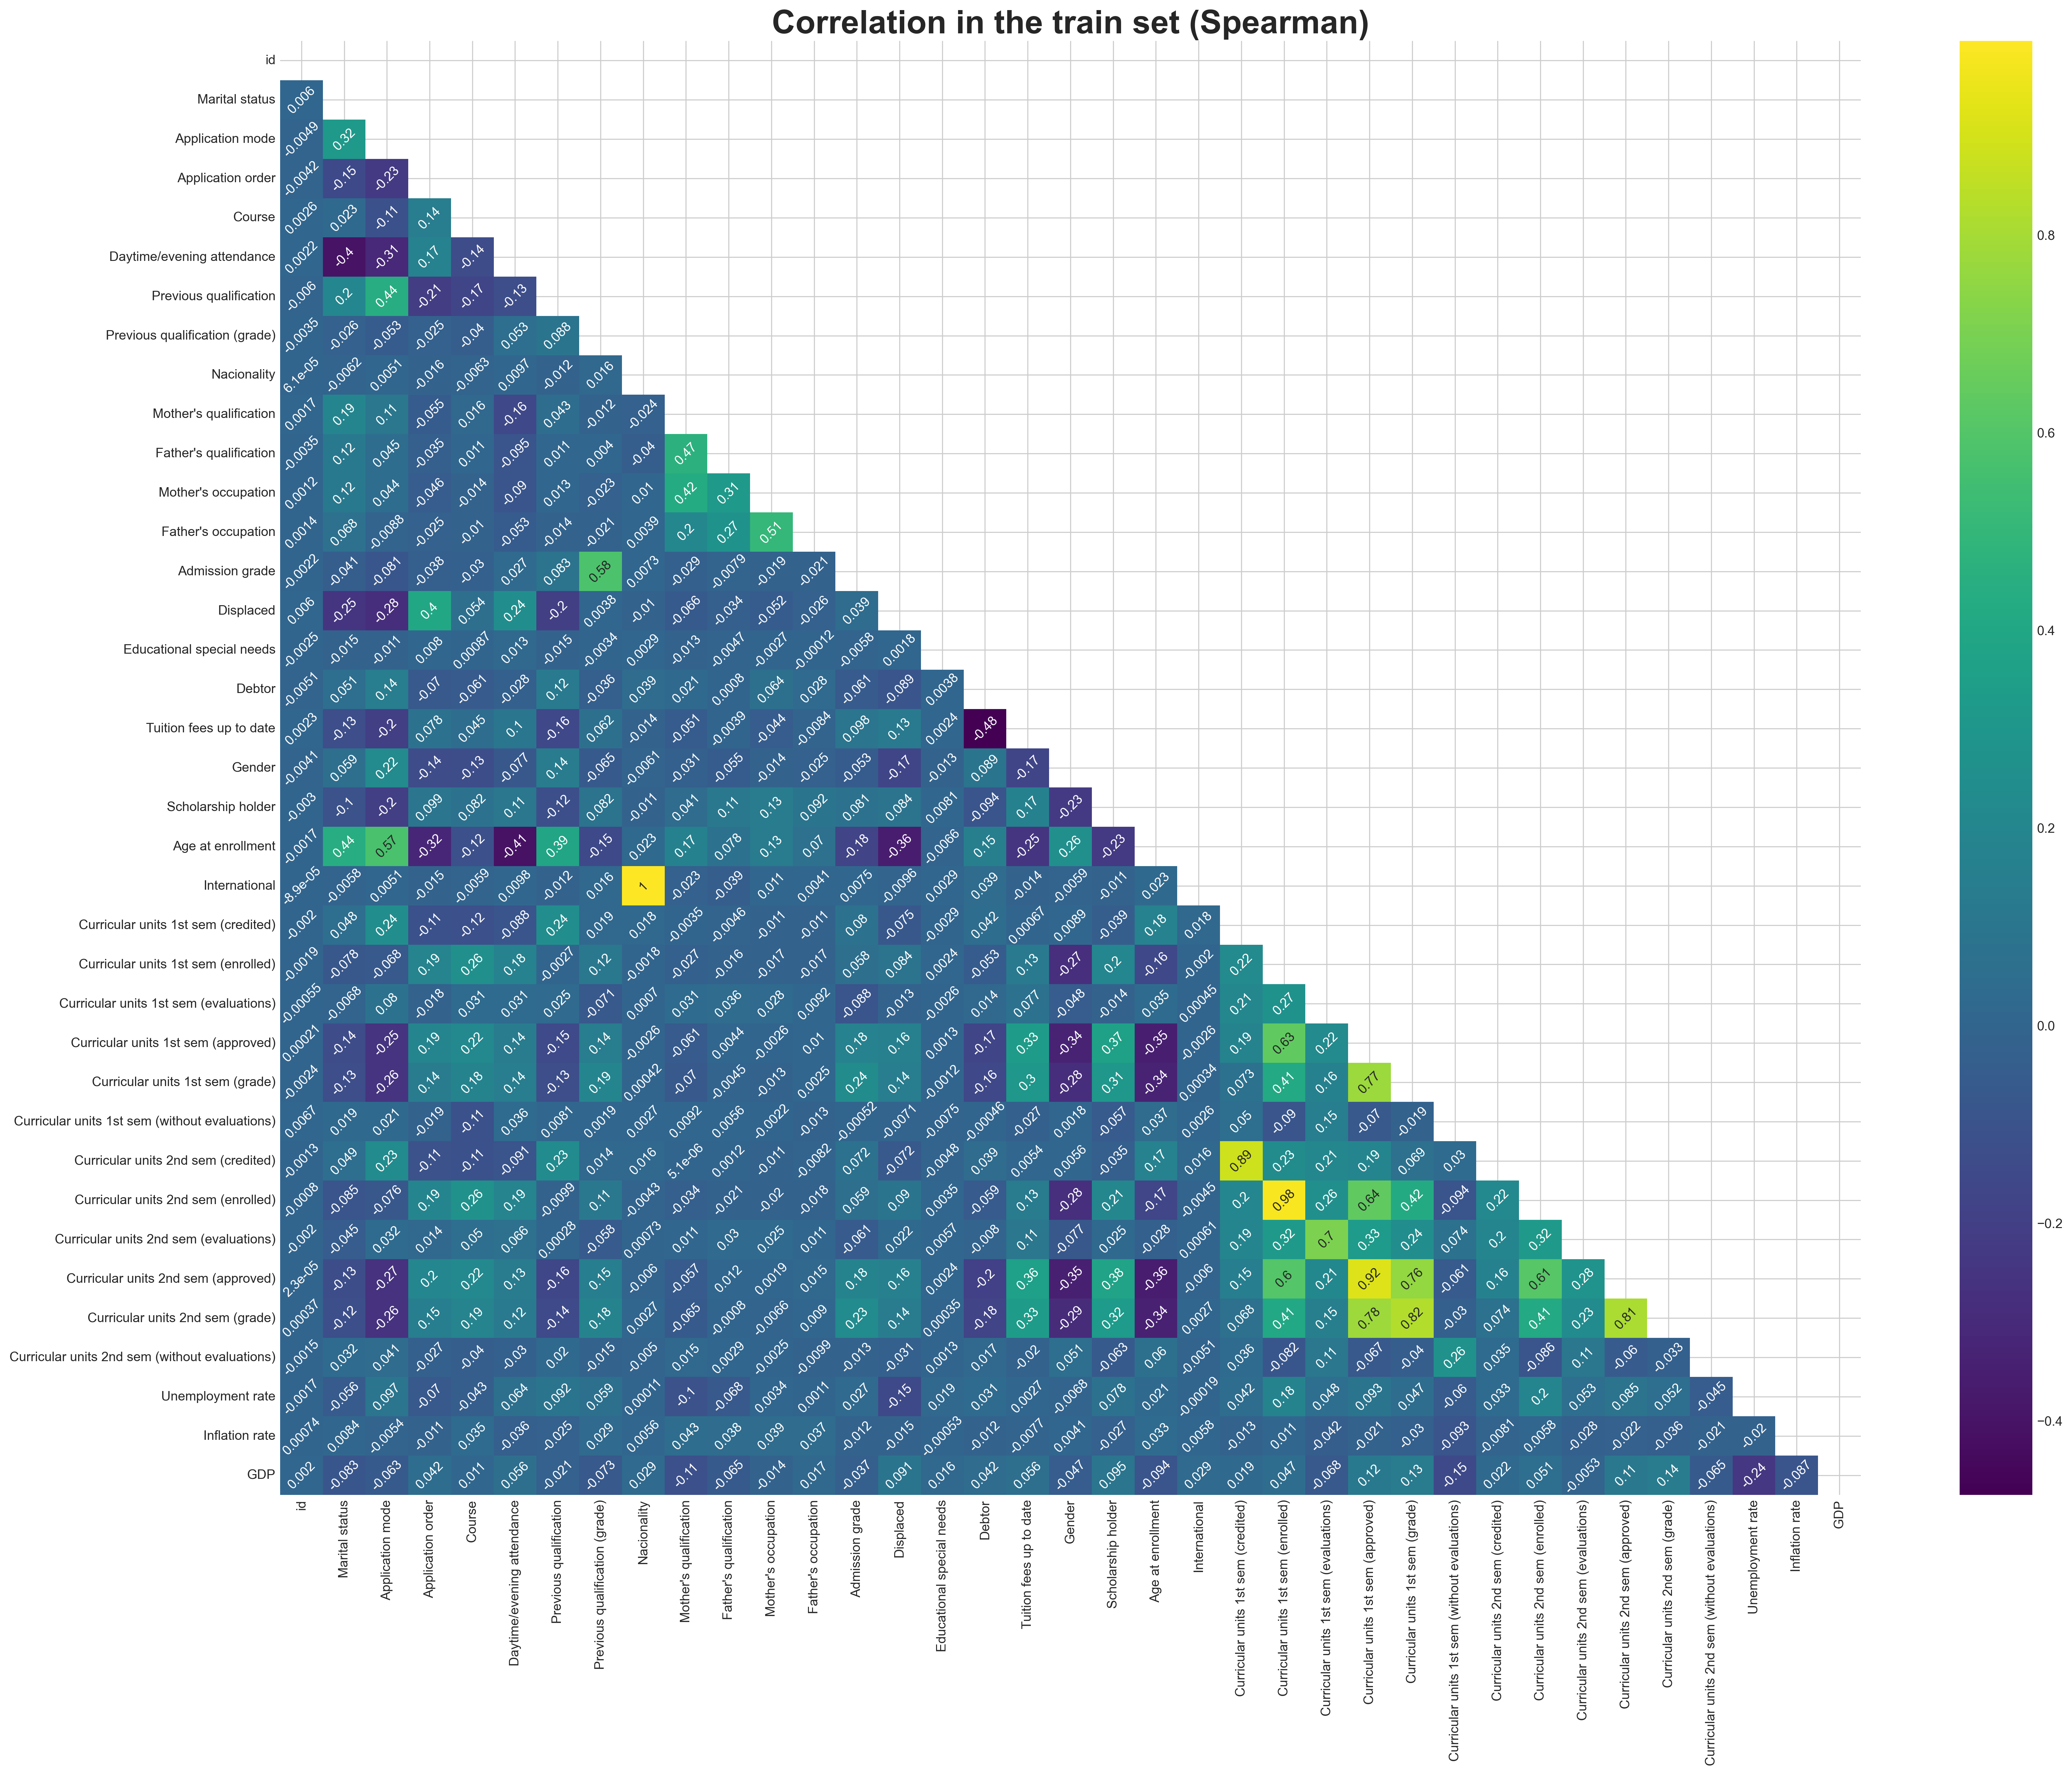

In [168]:
# To check how the features influence each other lets'plot a correlation matrix

# Drop the target column
corr = df.drop("Target", axis=1).corr(method='spearman') # spearman instead of pearson because of the expected non-linear effects

# Cover the up-right side with white cells
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True

# Initialize the plot
fig, ax = plt.subplots(figsize=(27,20), dpi=300)
sns.heatmap(data=corr, 
            mask=mask , 
            annot=True,
            cmap='viridis',
            annot_kws={'size': 10, 'rotation': 45}, # set the fontsize to 12 and rotate the text
            ax=ax
            );
ax.set_title(f'Correlation in the train set (Spearman)',fontsize=25, fontweight='bold')

This is a quite interesting correlation matrix. It is possible to observe that some dependencies are obvious, such like the 100% correlation between `Nacionality` and `International` or almost the whole down-right area where the enrolled and approved curricular units in the first 2 semesters are. In this case the strategy is to drop all the features with a high correlation, for example higher than 0.9 and to drop also the features with a low variance.

In [8]:
# Let's first find the features with a high correlation

# Calculate the correlation matrix
corr_matrix = df.drop("Target", axis=1).corr(method='spearman').abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

# Find features with correlation greater than 0.95
to_drop1 = [column for column in upper.columns if any(upper[column] > 0.9)]

print("Highly correlated features to drop:", to_drop1)

Highly correlated features to drop: ['International', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (approved)']


This tells us thatall the information contained in the `2nd sem (enrolled)` and `2nd sem (approved)` features is actually already contained in the `1st sem features`. If we think about it logically it makes sense. The first semester of university is a bottleneck for almost all careers. If someone didn't have a good performance in the first semester, it is very likely that the same will happen and the second semester and the they will dropout the career. So to avoid confusion while modelling we can drop out these features.

Low importance features to drop with an importance lower than 0.5%: ['Marital status', 'Daytime/evening attendance', 'Previous qualification', 'Nacionality', 'Educational special needs', 'International', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (without evaluations)']


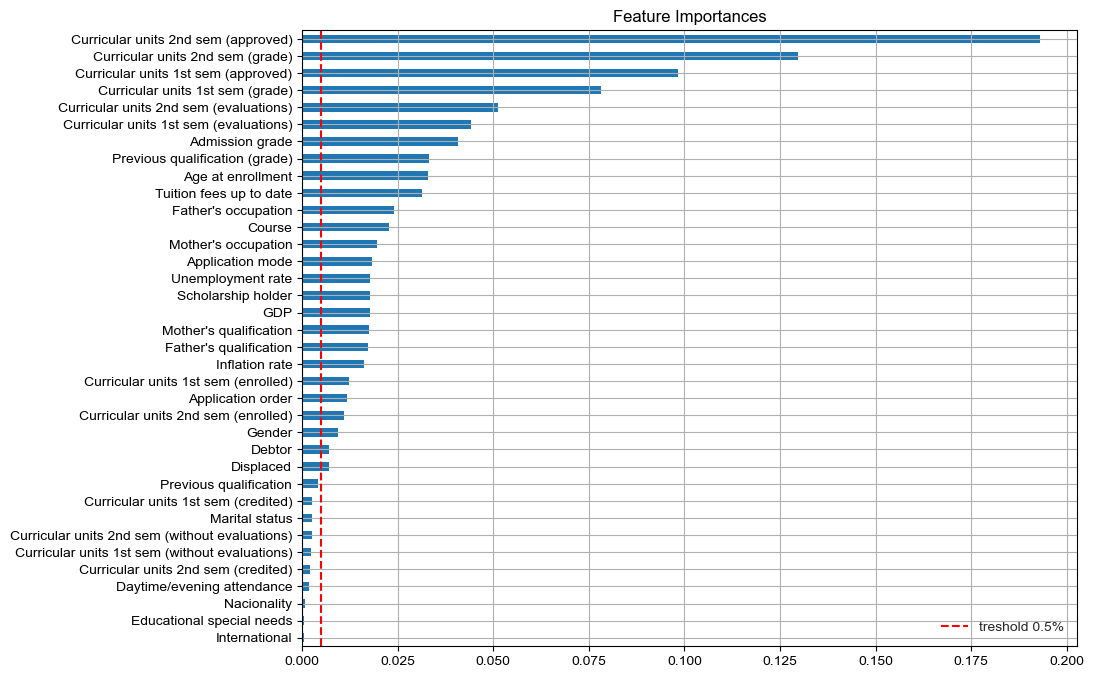

In [9]:
# Create the X and y sets

X = df.drop(["Target", "id"], axis=1)
y = df["Target"]

# Create and fit a RandomForestClassifier
model = RandomForestClassifier()
model.fit(X, y)

# Create a list with the features importances of all collumns
importances = model.feature_importances_
feature_importances = pd.Series(importances, index=X.columns)
# Get features with importance lower than the treshold
treshold = 0.005
to_drop2 = feature_importances[feature_importances < treshold].index.tolist()

print("Low importance features to drop with an importance lower than 0.5%:", to_drop2)

feature_importances.sort_values().plot(kind='barh', figsize=(10, 8))
plt.style.use('seaborn-v0_8-whitegrid')
plt.axvline(x=treshold, color='r', linestyle='--', label=f"treshold {treshold*100}%")
plt.grid(True)
plt.legend()
plt.title('Feature Importances')

The upper graph tells us also which features do not influence into the training of a RandomForestClassifier with no more than 5% (actually a lot of them), which also match the features we wanted to drop because of the correlation matrix. It would be also save to drop them in order to avoid confusion while modelling. Now before we continue it is necessary to look at the target column and look if it has a symmetric distribution.

Target
Graduate    47.416294
Dropout     33.058888
Enrolled    19.524818
Name: count, dtype: float64


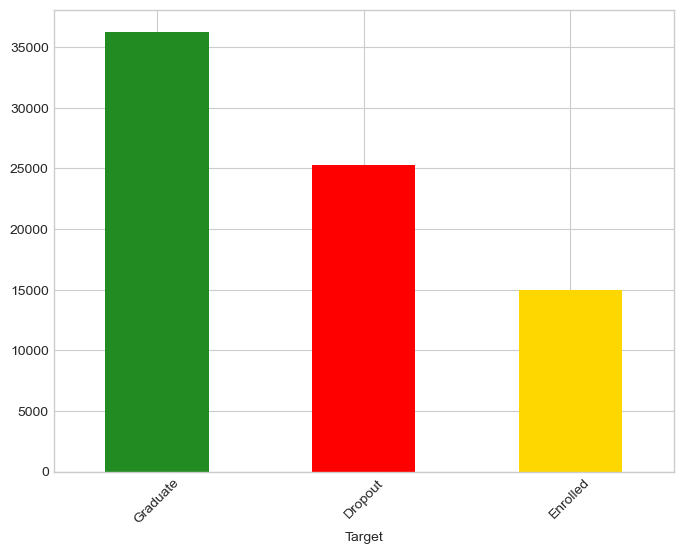

In [190]:
# Print the distributions in percent and then plot them
print(f"{df.Target.value_counts()/df.Target.count()*100}")
ax = df.Target.value_counts().plot(kind="bar", color=["forestgreen", "red", "gold"], figsize=(8, 6))

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Save the plot
plt.savefig("asymmetry_distribution")

In [187]:
df.Target.value_counts().axes

[Index(['Graduate', 'Dropout', 'Enrolled'], dtype='object', name='Target')]

As we can see, the distribution is moderately asymmetric, that's why it could be convenient to do some preprocess to balance the target distribution. For that we are gonna use the `imbalance-learn` library which has a very useful feature, which randomly deletes samples from the dominant parameter and also randomly adds entries corresponding to the other parameter. This function is called `SMOTETomek`.

In [11]:
# Create a temporal DataFrame if we want to restore the whole data
df_tmp = df.copy()

In [12]:
# First we must drop the features that could confuse the model
for item in to_drop2:
    if item not in to_drop1:
        to_drop1.append(item)
to_drop = to_drop1 + ["id"]
print(f"Features to be dropped: {to_drop}")

Features to be dropped: ['International', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (approved)', 'Marital status', 'Daytime/evening attendance', 'Previous qualification', 'Nacionality', 'Educational special needs', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (without evaluations)', 'id']


In [13]:
# Drop the features from the temporal DataFrame
df_tmp = df_tmp.drop(to_drop, axis=1)
df_tmp.shape, df.shape

((76518, 25), (76518, 38))

In [14]:
# Let's have a look of the first rows
df_tmp.head()

Application mode  Application order  Course  \
0                 1                  1    9238   
1                17                  1    9238   
2                17                  2    9254   
3                 1                  3    9500   
4                 1                  2    9500   

   Previous qualification (grade)  Mother's qualification  \
0                           126.0                       1   
1                           125.0                      19   
2                           137.0                       3   
3                           131.0                      19   
4                           132.0                      19   

   Father's qualification  Mother's occupation  Father's occupation  \
0                      19                    5                    5   
1                      19                    9                    9   
2                      19                    2                    3   
3                       3                    3                    2   
4                      37                    4                    9   

   Admission grade  Displaced  ...  Curricular units 1st sem (enrolled)  \
0            122.6          0  ...                                    6   
1            119.8          1  ...                                    6   
2            144.7          0  ...                                    6   
3            126.1          1  ...                                    7   
4            120.1          1  ...                                    7   

   Curricular units 1st sem (evaluations)  \
0                                       6   
1                                       8   
2                                       0   
3                                       9   
4                                      12   

   Curricular units 1st sem (approved)  Curricular units 1st sem (grade)  \
0                                    6                         14.500000   
1                                    4                         11.600000   
2                                    0                          0.000000   
3                                    7                         12.591250   
4                                    6                         12.933333   

   Curricular units 2nd sem (evaluations)  Curricular units 2nd sem (grade)  \
0                                       7                         12.428571   
1                                       9                          0.000000   
2                                       0                          0.000000   
3                                      11                         12.820000   
4                                      12                         12.933333   

   Unemployment rate  Inflation rate   GDP    Target  
0               11.1             0.6  2.02  Graduate  
1               11.1             0.6  2.02   Dropout  
2               16.2             0.3 -0.92   Dropout  
3               11.1             0.6  2.02  Enrolled  
4                7.6             2.6  0.32  Graduate  

[5 rows x 25 columns]

We finally have our data preprocessed, what if we model a `RandomForestClassifier` and show some metrics to see how good is our model even without hyperameter tuning.

In [15]:
# Import the metrics
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.combine import SMOTETomek

# Create the X and y sets
X = df_tmp.drop('Target', axis=1)
y = df_tmp['Target']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTETomek to balance the training data
smote_tomek = SMOTETomek(random_state=42)
X_res, y_res = smote_tomek.fit_resample(X_train, y_train)

# Train a Random Forest model with class weights
model = RandomForestClassifier(class_weight='balanced')
model.fit(X_res, y_res)

# Predict and evaluate
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[4033  682  344]
 [ 295 1954  739]
 [ 117  739 6401]]
              precision    recall  f1-score   support

     Dropout       0.91      0.80      0.85      5059
    Enrolled       0.58      0.65      0.61      2988
    Graduate       0.86      0.88      0.87      7257

    accuracy                           0.81     15304
   macro avg       0.78      0.78      0.78     15304
weighted avg       0.82      0.81      0.81     15304



Great!! We have a 81% accuracy before hyperparameter tuning! That looks very promising, let's visualize first the confusion matrix to better observe what the predicted and the actual target values are.

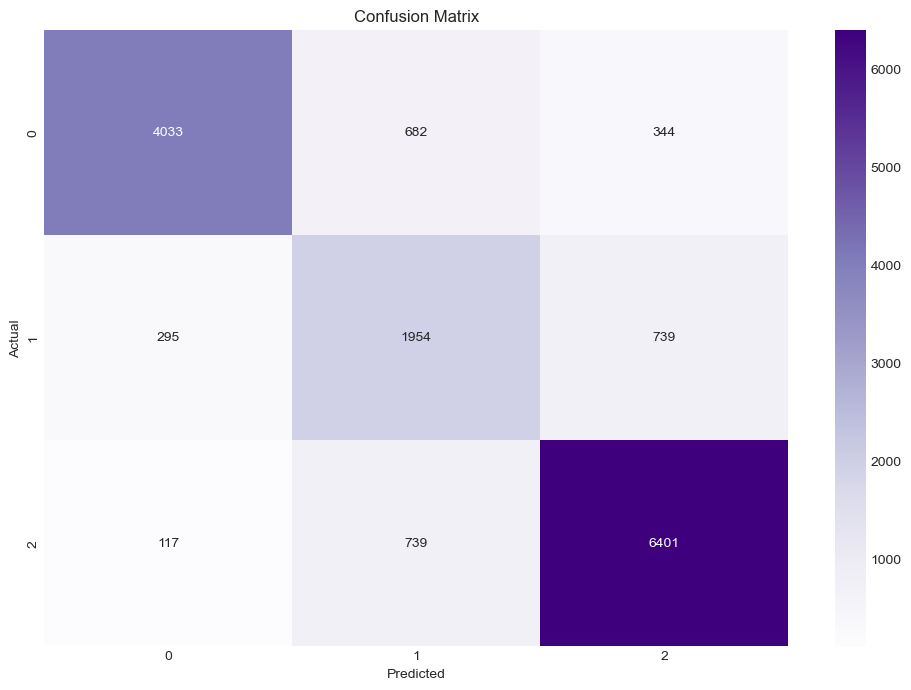

In [16]:
# Create the confusion matrix for the data
plt.figure(figsize=(12, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Purples')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

The values are mapped as:
* 0 : `Dropout`
* 1 : `Enrolled`
* 2 : `Graduate`

So we can easily observe, that the main confusion is created by the `Enrolled` parameter. A good approach would be to create a time dependant feature that could tell us if the student is still enrolled by analyzing for example the enrollment year and this year. Sadly the database does not contain this information and it is impossible (at least for me) to improve the performance of the model in that way. What we could do is to penalize the model each time it mislabels an `Enrolled` to the other parameters.

[[4042  642  375]
 [ 299 1872  817]
 [ 141  683 6433]]
              precision    recall  f1-score   support

     Dropout       0.90      0.80      0.85      5059
    Enrolled       0.59      0.63      0.61      2988
    Graduate       0.84      0.89      0.86      7257

    accuracy                           0.81     15304
   macro avg       0.78      0.77      0.77     15304
weighted avg       0.81      0.81      0.81     15304



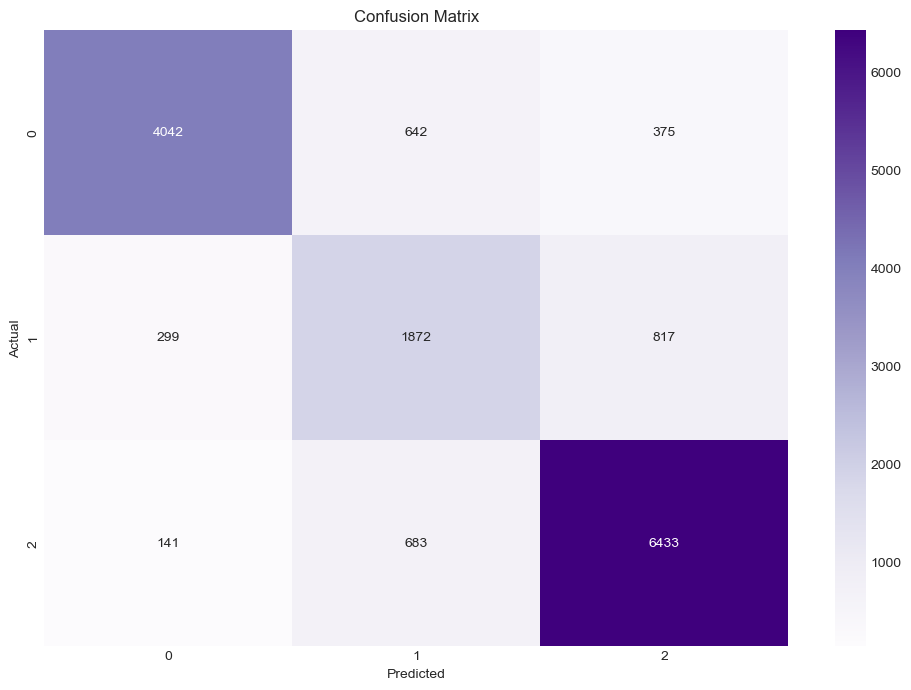

In [17]:
# Train a second Random Forest model with class weights
model2 = RandomForestClassifier(class_weight={'Dropout': 1, 'Enrolled': 3, 'Graduate': 1})
model2.fit(X_res, y_res)

# Predict and evaluate
y_pred2 = model2.predict(X_test)
print(confusion_matrix(y_test, y_pred2))
print(classification_report(y_test, y_pred2))

# Create the confusion matrix for the data
plt.figure(figsize=(12, 8))
sns.heatmap(confusion_matrix(y_test, y_pred2), annot=True, fmt='d', cmap='Purples')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

The value is almost the same, so we cannot expect an improvement by changing the weight further, but it was worth it to give it a try.

## Modelling

Now that we applied feature engineering on the data we can try some machine learning models to observe which can perform better on this data, for that we will use the models imported in the next few cells to ponderate their performance and the decide which of them fits better our requirements.

In [19]:
# Create a function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    '''
    Fits and evaluates given machine learning models.
    models : a dict of different Scikit-Learn machine learning models
    X_train : training data (no labels)
    X_test : testing data (no labels)
    y_train : training labels
    y_test : testing labels
    '''
    # Set random seed
    np.random.seed(42)
    # Make a dictionary to keep model scores
    model_scores = {}
    for name, model in models.items():
        # Fit the model to the data
        print(f"Fitting {name}...")
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        print(f"Evaluating {name}...")
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier

# Define models and their respective hyperparameter grids
models = {
    'RandomForest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'LightGBM': LGBMClassifier(),
    'MLP': MLPClassifier(),
    'SVC': SVC(),
    "Logistic Regression" : LogisticRegression(),
    "CatBoost Classifier" : CatBoostClassifier()
}

# In order to use the majority of these models we need to turn the values in the Target column into integers by mapping the y_res and y_test lists
mapping = {'Dropout' : 0,
           'Enrolled' : 1,
           'Graduate' : 2}
y_res, y_test = y_res.map(mapping), y_test.map(mapping)

model_scores = fit_and_score(models, X_res, X_test, y_res, y_test)
model_scores

Fitting RandomForest...
Evaluating RandomForest...
Fitting XGBoost...
Evaluating XGBoost...
Fitting LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2324
[LightGBM] [Info] Number of data points in the train set: 84305, number of used features: 24
[LightGBM] [Info] Start training from score -1.096042
[LightGBM] [Info] Start training from score -1.091403
[LightGBM] [Info] Start training from score -1.108470
Evaluating LightGBM...
Fitting MLP...
Evaluating MLP...
Fitting SVC...
Evaluating SVC...
Fitting Logistic Regression...


C:\Users\Asus\anaconda3\envs\titanic_env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Evaluating Logistic Regression...
Fitting CatBoost Classifier...
Learning rate set to 0.099207
0:	learn: 0.9977480	total: 213ms	remaining: 3m 33s
1:	learn: 0.9211417	total: 239ms	remaining: 1m 59s
2:	learn: 0.8596574	total: 262ms	remaining: 1m 27s
3:	learn: 0.8109256	total: 285ms	remaining: 1m 10s
4:	learn: 0.7692371	total: 306ms	remaining: 1m
5:	learn: 0.7354666	total: 331ms	remaining: 54.8s
6:	learn: 0.7071719	total: 357ms	remaining: 50.7s
7:	learn: 0.6821459	total: 386ms	remaining: 47.8s
8:	learn: 0.6609749	total: 415ms	remaining: 45.7s
9:	learn: 0.6412344	total: 442ms	remaining: 43.7s
10:	learn: 0.6249479	total: 467ms	remaining: 42s
11:	learn: 0.6104529	total: 493ms	remaining: 40.6s
12:	learn: 0.5977308	total: 519ms	remaining: 39.4s
13:	learn: 0.5863800	total: 544ms	remaining: 38.3s
14:	learn: 0.5768683	total: 569ms	remaining: 37.4s
15:	learn: 0.5682286	total: 595ms	remaining: 36.6s
16:	learn: 0.5604821	total: 622ms	remaining: 36s
17:	learn: 0.5530933	total: 651ms	remaining: 35.5s


{'RandomForest': 0.8090695243073707,
 'XGBoost': 0.8207658128593832,
 'LightGBM': 0.8157344485101934,
 'MLP': 0.7987454260324098,
 'SVC': 0.40244380554103504,
 'Logistic Regression': 0.6881860951385259,
 'CatBoost Classifier': 0.819916361735494}

It is important to emphasize that the time that each model required for training wasn't the same. Actually the SVC algorithm took way longer to train, almost a 100 times more compared to the others. 

**Note:** If we would like to decrease this number, we should simply decrease the training size but risking also a higher standard deviation of the true model's value. In this case because of the lower performance

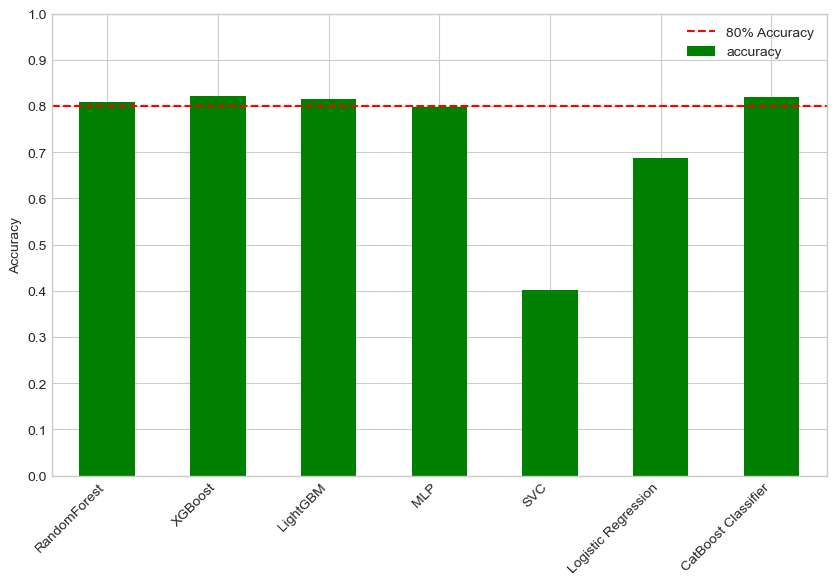

In [197]:
# Turn the dictionary into a DataFrame
model_compare = pd.DataFrame(model_scores, index=["accuracy"])

# Plot the bar chart with conditional colors
ax = model_compare.T.plot(kind='bar', color='green', legend=False, figsize=(10, 6))

# Add labels and title
ax.set_ylabel('Accuracy')
# ax.set_title('Model Comparison')
ax.set_ylim([0,1])
ax.set_yticks(np.arange(0, 1.1, step=0.1))
ax.set_xticklabels(model_compare.columns, rotation=45, ha='right')

# Add a horizontal line for the accuracy limit
ax.axhline(y=0.8, c='r', linestyle='--', label='80% Accuracy')
plt.legend()


# Show the plot
plt.show()

For further hyperparameter tuning we will keep working only with the models that had an accuracy higher than 80%

In [59]:
# Select only the models with an accuracy higher than 80%
filtered_models = {model : score for model, score in model_scores.items() if score > 0.80}
filtered_models

{'RandomForest': 0.8090695243073707,
 'XGBoost': 0.8207658128593832,
 'LightGBM': 0.8157344485101934,
 'CatBoost Classifier': 0.819916361735494}

In [35]:
best_models = {
    'RandomForest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'LightGBM': LGBMClassifier(),
    'MLP': MLPClassifier(),
    "CatBoost Classifier" : CatBoostClassifier()
}
# Create the X and y sets
X = df_tmp.drop('Target', axis=1)
y = df_tmp['Target']
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Set random seed
np.random.seed(42)
y_train, y_test = y_train.map(mapping), y_test.map(mapping)
# Make a dictionary to keep model scores
model_scores1 = {}
for name, model in best_models.items():
    # Fit the model to the data
    print(f"Fitting {name}...")
    model.fit(X_train, y_train)
    # Evaluate the model and append its score to model_scores
    print(f"Evaluating {name}...")
    model_scores1[name] = model.score(X_test, y_test)

Fitting RandomForest...
Evaluating RandomForest...
Fitting XGBoost...
Evaluating XGBoost...
Fitting LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1224
[LightGBM] [Info] Number of data points in the train set: 61214, number of used features: 24
[LightGBM] [Info] Start training from score -1.106863
[LightGBM] [Info] Start training from score -1.633477
[LightGBM] [Info] Start training from score -0.746218
Evaluating LightGBM...
Fitting MLP...
Evaluating MLP...
Fitting CatBoost Classifier...
Learning rate set to 0.097601
0:	learn: 1.0001038	total: 19.3ms	remaining: 19.3s
1:	learn: 0.9224932	total: 36ms	remaining: 18s
2:	learn: 0.8622153	total: 53.8ms	remaining: 17.9s
3:	learn: 0.8136269	total: 70.8ms	remaining: 17.6s
4:	learn: 0.7730556	total: 93ms	remainin

This is part of experimenting and trying to improve the trained models, sometimes doing nothing is better than changing something. The change is not very high but it is clear that all models improved almost 1% without the target balancing techniques. Thus we will continue the training without resample techniques. 

### Hyperparameter tuning

Now that we compared the performance of all models, it could be worth it to check if we can improve the accuracy of the best models further by applying hyperparameter tuning. For this firstly we will try some random tuning using `RandomizedSearchCV()` to compare the results with the default settings of the models and make further decisions about which parameters will be later tuned using `GridSearchCV()`

In [61]:
# Import the RandomizedSearchCV function
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grids for each model
param_grids = {
    'RandomForestClassifier': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'XGBClassifier': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 6, 9],
        'colsample_bytree': [0.3, 0.7, 1]
    },
    'LGBMClassifier': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'num_leaves': [31, 61, 91],
        'boosting_type': ['gbdt', 'dart']
    },
    'CatBoostClassifier': {
        'iterations': np.linspace(100, 1000, 10, dtype=int),
        'learning_rate': [0.01, 0.05, 0.1],
        'depth': [4, 6, 8, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9],
        'border_count': [32, 50, 100, 150, 200],
        'bagging_temperature': [0.1, 0.2, 0.5, 0.8, 1],
        'random_strength': [1, 2, 5, 10],
        'leaf_estimation_iterations': [1, 5, 10]
    }
}

# Create the X and y sets
X = df_tmp.drop('Target', axis=1)
y = df_tmp['Target']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

y_train, y_test = y_train.map(mapping), y_test.map(mapping)

# Store the results
best_models = {}
best_scores = {}


# Iterate over the models and their parameter grids
for model_name, params in param_grids.items():
    if model_name == 'RandomForestClassifier':
        model = RandomForestClassifier(random_state=42)
    elif model_name == 'XGBClassifier':
        model = XGBClassifier(random_state=42)
    elif model_name == 'LGBMClassifier':
        model = LGBMClassifier(random_state=42)
    elif model_name == 'CatBoostClassifier':
        model = CatBoostClassifier(silent=True, random_state=42)

    # Setup the randomized search
    random_search = RandomizedSearchCV(estimator=model, param_distributions=params, 
                                       n_iter=25, scoring='accuracy', cv=5, verbose=1, n_jobs=-1, random_state=42)
    
    # Fit the randomized search
    random_search.fit(X_train, y_train)
    
    # Store the best parameters and best score
    best_models[model_name] = random_search.best_params_
    best_scores[model_name] = random_search.best_score_

# Print the best parameters and scores
for model_name in best_models.keys():
    print(f"Best parameters for {model_name}: {best_models[model_name]}")
    print(f"Best score for {model_name}: {best_scores[model_name]}")

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1224
[LightGBM] [Info] Number of data points in the train set: 61214, number of used features: 24
[LightGBM] [Info] Start training from score -1.106863
[LightGBM] [Info] Start training from score -1.633477
[LightGBM] [Info] Start training from score -0.746218
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters for RandomForestClassifier: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': None}
Best score for RandomFore

In [113]:
# Let's have a look on the scores
best_scores

{'RandomForestClassifier': 0.8138824898298163,
 'XGBClassifier': 0.8206783232580597,
 'LGBMClassifier': 0.8187833508628298,
 'CatBoostClassifier': 0.8196328318761761}

In [114]:
# And also of the parameters
best_models

{'RandomForestClassifier': {'n_estimators': 200,
  'min_samples_split': 5,
  'min_samples_leaf': 4,
  'max_depth': None},
 'XGBClassifier': {'n_estimators': 200,
  'max_depth': 6,
  'learning_rate': 0.2,
  'colsample_bytree': 0.3},
 'LGBMClassifier': {'num_leaves': 31,
  'n_estimators': 200,
  'learning_rate': 0.2,
  'boosting_type': 'dart'},
 'CatBoostClassifier': {'random_strength': 2,
  'learning_rate': 0.1,
  'leaf_estimation_iterations': 1,
  'l2_leaf_reg': 5,
  'iterations': 400,
  'depth': 6,
  'border_count': 200,
  'bagging_temperature': 0.2}}

Now we can plot the results against the scores obtained for the default parameters to decide which parameters will be searched using `GridSearchCV()`

In [112]:
# Calculate the performance difference before and after RandomSearchCV
difference = [a - b for a, b in zip(best_scores.values(), filtered_models.values())]
difference

[0.004812965522445589,
 -8.748960132354267e-05,
 0.00304890235263644,
 -0.0002835298593178992]

C:\Users\Asus\AppData\Local\Temp\ipykernel_13956\4238662670.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(best_scores.keys(), rotation=45, ha='right')


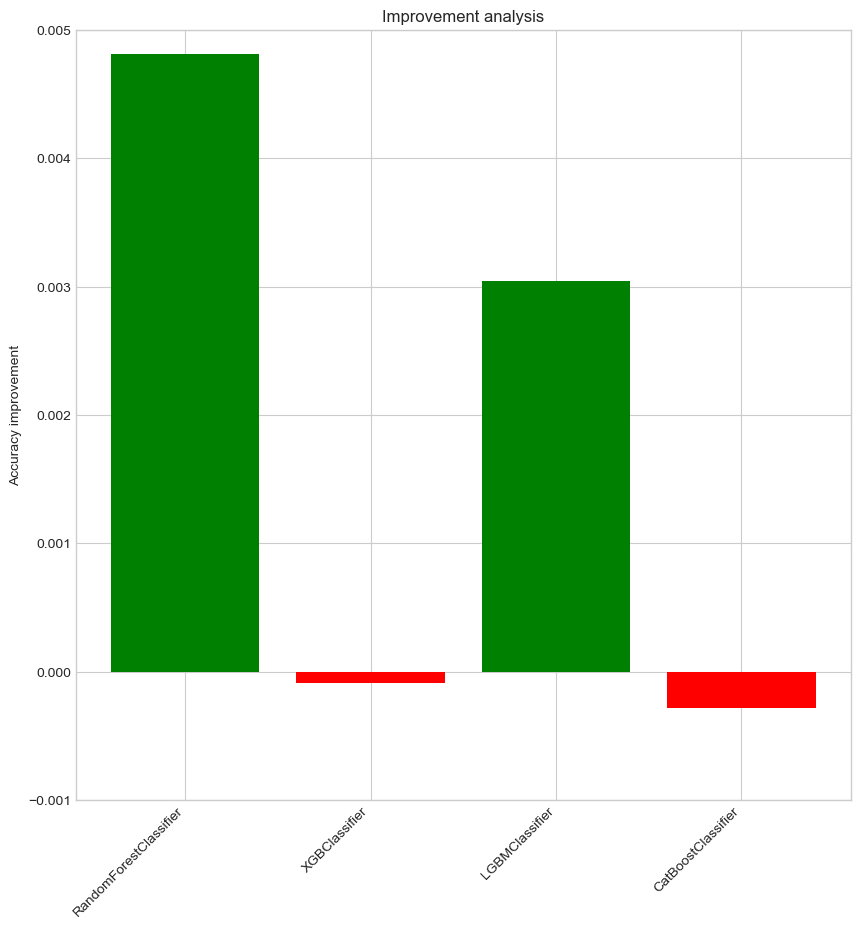

In [200]:
colors = ['green' if score > 0 else 'red' for score in difference]
fig, ax = plt.subplots(figsize=(10, 10))
ax.bar(best_scores.keys(), difference, color=colors)

# Add labels and title
ax.set_ylabel('Accuracy improvement')
ax.set_title('Improvement analysis')
ax.set_ylim([-0.001, 0.005])
ax.set_xticklabels(best_scores.keys(), rotation=45, ha='right')
plt.savefig("improvement.png")

We can observe that both the `RandomForestClassifier` and the `LGBMClassifier` had a considerable improvement of almost 5%, while the other two models performed a bit worse than before the hyperparameter tuning. For this reason we will consider all four models for hyperparameter tuning using `GridSearchCV()` hoping their performance to improve. We will take the approach in which we assume the hyperparameters of these models are already approaching a maximum in performance, so the parameters found by using `RandomSearchCV()` will only be changed a bit.

In [115]:
best_models

{'RandomForestClassifier': {'n_estimators': 200,
  'min_samples_split': 5,
  'min_samples_leaf': 4,
  'max_depth': None},
 'XGBClassifier': {'n_estimators': 200,
  'max_depth': 6,
  'learning_rate': 0.2,
  'colsample_bytree': 0.3},
 'LGBMClassifier': {'num_leaves': 31,
  'n_estimators': 200,
  'learning_rate': 0.2,
  'boosting_type': 'dart'},
 'CatBoostClassifier': {'random_strength': 2,
  'learning_rate': 0.1,
  'leaf_estimation_iterations': 1,
  'l2_leaf_reg': 5,
  'iterations': 400,
  'depth': 6,
  'border_count': 200,
  'bagging_temperature': 0.2}}

In [119]:
# Import the RandomizedSearchCV function
from sklearn.model_selection import GridSearchCV

# Define parameter grids for each model
param_grids_GS = {
    'RandomForestClassifier': {
        'n_estimators': [190, 200, 210],
        'max_depth': [None],
        'min_samples_split': [4, 5, 6],
        'min_samples_leaf': [3, 4, 5]
    },
    'XGBClassifier': {
        'n_estimators': [190, 200, 210],
        'learning_rate': [0.2, 0.5, 1],
        'max_depth': [5, 6, 7],
        'colsample_bytree': [0.2, 0.3, 0.4]
    },
    'LGBMClassifier': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'num_leaves': [21, 31, 41],
        'boosting_type': ['dart']
    },
    'CatBoostClassifier': {
        'iterations': np.linspace(300, 500, 3, dtype=int),
        'learning_rate': [0.1, 1],
        'depth': [5, 6, 7],
        'l2_leaf_reg': [4, 5, 6],
        'bagging_temperature': [0.2, 0.3],
        'random_strength': [2, 3]
    }
}

# Store the results
best_models_GS = {}
best_scores_GS = {}


# Iterate over the models and their parameter grids
for model_name, params in param_grids_GS.items():
    if model_name == 'RandomForestClassifier':
        model = RandomForestClassifier(random_state=42)
    elif model_name == 'XGBClassifier':
        model = XGBClassifier(random_state=42)
    elif model_name == 'LGBMClassifier':
        model = LGBMClassifier(random_state=42)
    elif model_name == 'CatBoostClassifier':
        model = CatBoostClassifier(silent=True, random_state=42)

    # Setup the randomized search
    grid_search = GridSearchCV(estimator=model, param_grid=params, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
    
    # Fit the randomized search
    grid_search.fit(X_train, y_train)
    
    # Store the best parameters and best score
    best_models_GS[model_name] = grid_search.best_params_
    best_scores_GS[model_name] = grid_search.best_score_

# Print the best parameters and scores
for model_name in best_models_GS.keys():
    print(f"Best parameters for {model_name}: {best_models_GS[model_name]}")
    print(f"Best score for {model_name}: {best_scores_GS[model_name]}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1224
[LightGBM] [Info] Number of data points in the train set: 61214, number of used features: 24
[LightGBM] [Info] Start training from score -1.106863
[LightGBM] [Info] Start training from score -1.633477
[LightGBM] [Info] Start training from score -0.746218
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters for RandomForestClassifier: {'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 200}
Best score for RandomForestClassifier: 0.8139968649069702
Best parameters for XGBClassi

In [120]:
# Let's look now at the improvement achieved compared to the random tuning
difference_search = [a - b for a, b in zip(best_scores_GS.values(), best_scores.values())]
difference_search

[0.00011437507715394979,
 0.0011762316814825091,
 0.0007187780772687224,
 0.0004574309192189041]

C:\Users\Asus\AppData\Local\Temp\ipykernel_13956\798858417.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(best_scores.keys(), rotation=45, ha='right')


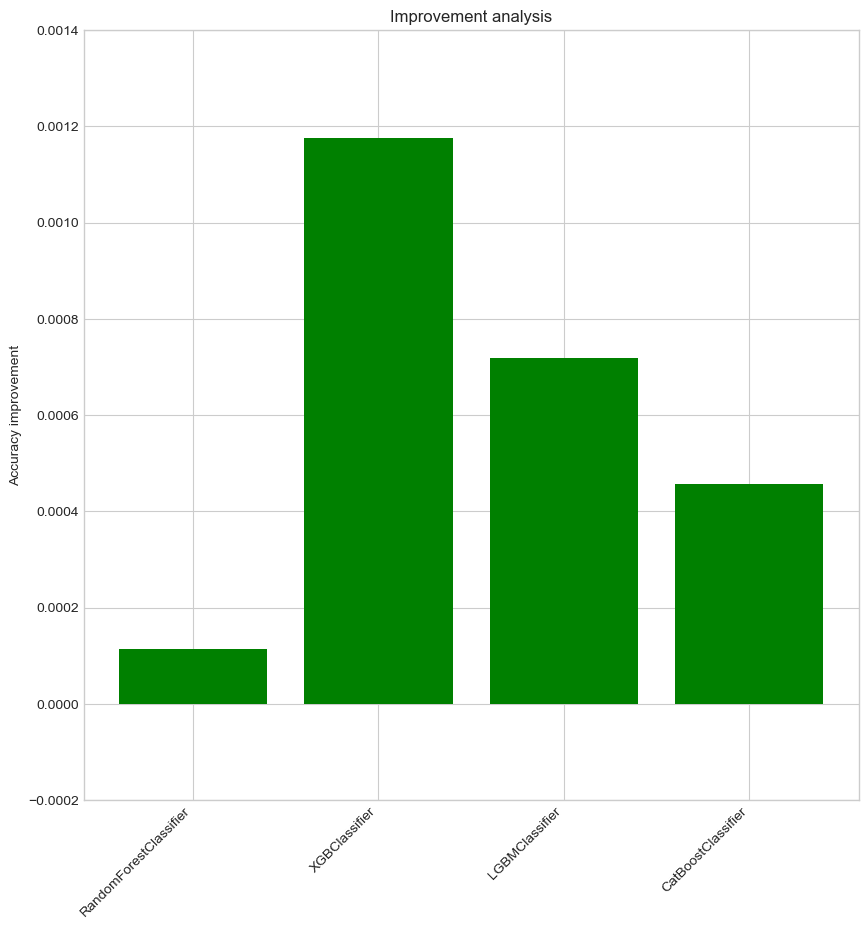

In [204]:
# Visualize
colors = ['green' if score > 0 else 'red' for score in difference_search]
fig, ax = plt.subplots(figsize=(10, 10))
ax.bar(best_scores.keys(), difference_search, color=colors)

# Add labels and title
ax.set_ylabel('Accuracy improvement')
ax.set_title('Improvement analysis')
ax.set_ylim([-0.0002, 0.0014])
ax.set_xticklabels(best_scores.keys(), rotation=45, ha='right')
plt.savefig("grid_search_improvement.png")

Specially `XGBClassifier` showed an increase in its performance by reaching an accuracy of almost 82.2%

**Conclusion:** The best hyperparameters found using `GridSearchCV()` for `XGBClassifier` will be used to train the definitive model we'll be using to submit our predictions for this Kaggle competition.

In [132]:
# Create X & y sets
X = df_tmp.drop('Target', axis=1)
y = df_tmp['Target']

# Map the y set
y = y.map(mapping)

# Apply SMOTETomek to balance the training data
smote_tomek = SMOTETomek(random_state=42)
X, y = smote_tomek.fit_resample(X, y)

# Train & test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Create the model
model = XGBClassifier(colsample_bytree=0.2,
                      learning_rate=0.2,
                      max_depth=5,
                      n_estimators=200)

# Fit the data
model.fit(X_train, y_train)

# Score the data
model.score(X_test, y_test)

0.8524799848405893

In [127]:
# Load the test data
df_test = pd.read_csv("data/test.csv")
df_test.head()

id  Marital status  Application mode  Application order  Course  \
0  76518               1                 1                  1    9500   
1  76519               1                 1                  1    9238   
2  76520               1                 1                  1    9238   
3  76521               1                44                  1    9147   
4  76522               1                39                  1    9670   

   Daytime/evening attendance  Previous qualification  \
0                           1                       1   
1                           1                       1   
2                           1                       1   
3                           1                      39   
4                           1                       1   

   Previous qualification (grade)  Nacionality  Mother's qualification  ...  \
0                           141.0            1                       3  ...   
1                           128.0            1                       1  ...   
2                           118.0            1                       1  ...   
3                           130.0            1                       1  ...   
4                           110.0            1                       1  ...   

   Curricular units 1st sem (without evaluations)  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   

   Curricular units 2nd sem (credited)  Curricular units 2nd sem (enrolled)  \
0                                    0                                    8   
1                                    0                                    6   
2                                    0                                    6   
3                                    3                                    8   
4                                    0                                    6   

   Curricular units 2nd sem (evaluations)  \
0                                       0   
1                                       6   
2                                      11   
3                                      14   
4                                       9   

   Curricular units 2nd sem (approved)  Curricular units 2nd sem (grade)  \
0                                    0                          0.000000   
1                                    6                         13.500000   
2                                    5                         11.000000   
3                                    5                         11.000000   
4                                    4                         10.666667   

   Curricular units 2nd sem (without evaluations)  Unemployment rate  \
0                                               0               13.9   
1                                               0               11.1   
2                                               0               15.5   
3                                               0                8.9   
4                                               2                7.6   

   Inflation rate   GDP  
0            -0.3  0.79  
1             0.6  2.02  
2             2.8 -4.06  
3             1.4  3.51  
4             2.6  0.32  

[5 rows x 37 columns]

In [130]:
# Check its shape
df_test.shape

(51012, 37)

In [133]:
# Preprocess the data to match it with the 
df_test = df_test.drop(to_drop, axis=1)

In [134]:
# Check if it worked
df_test.shape

(51012, 24)

In [141]:
# Great! Now we can predict the values from the test set
y_preds = model.predict(df_test)

In [142]:
# Check the predictions 
y_preds

array([0, 2, 2, ..., 0, 0, 0], dtype=int64)

In [143]:
# Now we have to remap again to have strings instead of integers
mapping_inv = {0 : 'Dropout',
               1 : 'Enrolled',
               2 : 'Graduate'}

# Transform the numpy array into a pandas Series
y_preds = pd.Series(y_preds)

# Map the values
y_preds = y_preds.map(mapping_inv)

# Check if it worked
y_preds

0         Dropout
1        Graduate
2        Graduate
3        Enrolled
4        Enrolled
           ...   
51007     Dropout
51008     Dropout
51009     Dropout
51010     Dropout
51011     Dropout
Length: 51012, dtype: object

In [157]:
# Load the dataframe again, because while preprocessing we deleted the id column
df_test = pd.read_csv("data/test.csv")

# Create the id column
student_id = df_test['id']
student_id

0         76518
1         76519
2         76520
3         76521
4         76522
          ...  
51007    127525
51008    127526
51009    127527
51010    127528
51011    127529
Name: id, Length: 51012, dtype: int64

In [159]:
# Create the sample submission
data = {'id' : student_id,
        'Target' : y_preds} 

submission = pd.DataFrame(data)
submission.head()

id    Target
0  76518   Dropout
1  76519  Graduate
2  76520  Graduate
3  76521  Enrolled
4  76522  Enrolled

In [161]:
# Save the DataFrame as a csv file
submission.to_csv("submission.csv", index=False)

Great! Now the only that we have to do is to submit the file in the competition and hope for the best!

## Neural Network Training

The data offered for this problem is actually quite big, with more than 70k entries, that's why it could be a good idea to try a deep learning model to let the neural network to find itself patterns in the data and create a more robust model, where bot feature engineering and training are condensed into one step. For that we will use the `TensorFlow` library. In the next cell we give the problem a first try to see if it is worth it to keep trying further wit hyperparameter tuning.

**Note:** For a Neural Network Training in most part of the cases a GPU would be needed reduce computation time. For that `Google Colab` lets us use a powerful GPU from the Google Servers only for a reduced period of time, which should be enough for not very complicated models. A better and deeper explanation of how to use GPU for tensorflow in colab can be found here: https://colab.research.google.com/notebooks/gpu.ipynb 

Epoch 1/100
957/957 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.4021 - loss: -684.4102 - val_accuracy: 0.3918 - val_loss: -5399.1748 - learning_rate: 0.0010
Epoch 2/100
957/957 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4124 - loss: -8276.5068 - val_accuracy: 0.4196 - val_loss: -20104.7227 - learning_rate: 0.0010
Epoch 3/100
957/957 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4073 - loss: -24950.1816 - val_accuracy: 0.4171 - val_loss: -43349.4531 - learning_rate: 0.0010
Epoch 4/100
957/957 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3999 - loss: -50714.1484 - val_accuracy: 0.4317 - val_loss: -77827.8359 - learning_rate: 0.0010
Epoch 5/100
957/957 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4004 - loss: -85720.0000 - val_accuracy: 0.4285 - val_loss: -122366.1406 - learning_rate: 0.0010
Epoch 6/100
957/957 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4015 - loss: -128884.1641 - val_accuracy: 0.4328 - val_loss: -173236.6250 - learning_rate: 0.0010
Epoch 7/100
957/957 ━━━

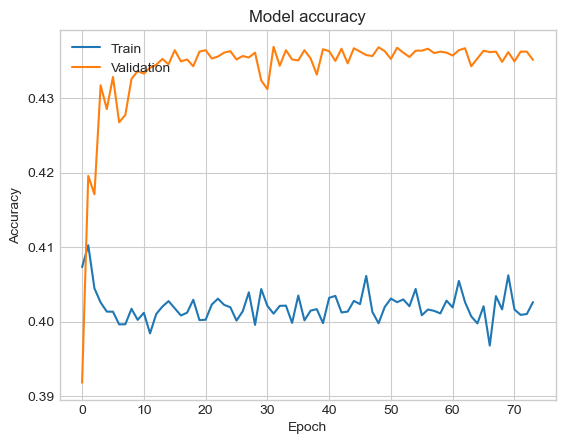

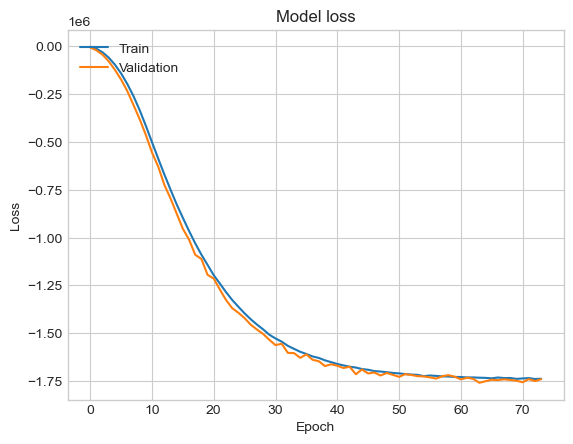

In [117]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import Adam, Nadam, SGD, RMSprop
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the model
model = tf.keras.Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(256, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(256, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(256, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001, momentum=0.8), 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
# Learning scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))
lr_scheduler = LearningRateScheduler(scheduler)

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=64, validation_data=(X_test_scaled, y_test), 
                    callbacks=[early_stopping, reduce_lr, lr_scheduler])

# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Results:** After playing with the code a few times we noted, that it is not worth it (maybe due also to our lack of knowledge in deep learning) to keep trying to model a neural network because of the poor performance it showed, reaching at its maximum an accuracy of almost 45%. So for this time we will keep on the "traditional" machine learning modelling track.